Import necessary libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import cv2
import os
import time
import string

from random import choice, sample
from IPython.display import clear_output

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPool1D, Dense, Embedding, GRU, \
    Bidirectional, Concatenate, Lambda, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.python.keras.utils.data_utils import Sequence

from helper_functions import *

In [5]:
print(tf.__version__)

2.1.0


Check whether GPUs are available

In [6]:
get_available_gpus()

[]

In [4]:
clean_test_fbumper = pd.read_csv('/data/data_for_thevin/clean_test_set/fbumper_ud_test.csv')

In [5]:
clean_fbumper = clean_test_fbumper.loc[clean_test_fbumper['fbumper_part_scores'] > 0.5]

In [ ]:
clean_fbumper.head()

In [7]:
mappings = pd.read_csv('/data/data_for_thevin/mapping/mapping_may20.csv')

In [ ]:
mappings.loc[mappings['t_part'] == 'bonnet']

In [9]:
dict_ = mappings.to_dict('split')

In [10]:
map_dict = {}
for i in dict_['data']:
    map_dict[i[0]] = i[1]

In [11]:
mapping_keys = np.unique(mappings['t_part'].values)

In [12]:
mapping_dict = {}
for i in mapping_keys:
    mapping_dict[i] = mappings.loc[mappings['t_part'] == i, 'description'].values.tolist()

## First csv Analysis

In [13]:
data = pd.read_csv('/data/data_for_thevin/claim_split/imbag_to_image_id_mapping_with_part_scores.csv')

In [ ]:
data.head()

In [14]:
len(data)

1861458

In [15]:
data.columns

Index(['image_id', 'imbag_id', 'RecordID', 'set', 'fbumper', 'bbumper',
       'bonnet', 'bootlid', 'flwing', 'blwing', 'fldoor', 'rldoor', 'frwing',
       'brwing', 'frdoor', 'rrdoor', 'grille', 'rheadlamp', 'rtaillamp',
       'rmirror', 'lheadlamp', 'ltaillamp', 'lmirror', 'lrockerpanel',
       'rrockerpanel', 'fwindshield', 'rwindshield'],
      dtype='object')

In [88]:
fbumper_data = data.loc[(data['fbumper'] > 0.5) & (data['flwing'] < 0.5) & (data['frwing'] < 0.5)]

In [89]:
len(fbumper_data)

85227

In [ ]:
fbumper_data.loc[fbumper_data['']]

In [ ]:
sorted_data = data.sort_values(by = ['RecordID', 'imbag_id'])
sorted_data

In [144]:
#We know that there are an equal number of record id's and imbag id's

unq_imbag_id = np.unique(sorted_data.values[:, 1])
unq_record_id = np.unique(sorted_data.values[:, 2])

assert len(unq_imbag_id) == len(unq_record_id)
len(unq_imbag_id)

99960

## Metadata csv Analysis

In [ ]:
metadata = pd.read_csv('/data/data_for_thevin/metadata/metadata_100k_claims.csv')
metadata.head()

In [ ]:
metadata.columns

In [147]:
#There are less entries in the metadata than unique record id's in the data
len(metadata)

99678

## Line Level csv Analysis

In [ ]:
line_level = pd.read_csv('/data/data_for_thevin/line_level/line_level_100k_claims.csv')
line_level

In [16]:
len(line_level)

3288374

In [16]:
line_level.columns

Index(['RecordID', 'DiscountAmount', 'IsLaborTaxable', 'IsPartTaxable',
       'LaborHours', 'LaborOperation', 'LaborRate', 'LaborType',
       'LineDescription', 'NetCost', 'PartNumber', 'PartPrice', 'PartQuantity',
       'PartType', 'TotalLaborCharges', 'VIN14'],
      dtype='object')

In [151]:
# There are less record ids in line_level.csv compared to data

line_level_r_ids = np.unique(list(line_level.values[:, 0]))
len(line_level_r_ids)

99825

In [152]:
from collections import Counter

count = Counter(list(line_level['LaborOperation']))
count.most_common(25)

[('Remove/Replace', 1108089),
 ('Remove/Install', 738278),
 ('Refinish', 399803),
 ('Repair', 235290),
 ('Additional Operations', 148160),
 ('Additional Costs', 142040),
 ('Blank', 126673),
 ('Additional Labor', 120736),
 ('Blend', 73958),
 ('Sublet', 64165),
 ('Overhaul', 43427),
 ('Refinish/Repair', 30179),
 (nan, 22938),
 ('Check/Adjust', 21583),
 ('Alignment', 7295),
 ('Remove/Replace, Partial', 2397),
 ('Inspect', 1803),
 ('Repair, Partial', 1560)]

In [153]:
from collections import Counter

count = Counter(list(line_level['LineDescription']))
count.most_common(25)

[('Rear Bumper Cover', 48791),
 ('Frt Bumper Cover', 48687),
 ('Clear Coat', 47188),
 ('Hazardous Waste Disposal', 39033),
 ('Paint/Materials', 35267),
 ('Flex Additive', 27699),
 ('Cover,Front Bumper', 22818),
 ('Cover,Rear Bumper', 20522),
 ('Fender,Front           LT', 17333),
 ('Fender,Front           RT', 17207),
 ('Panel,Hood', 16746),
 ('Frt Bumper Cover Assy', 15625),
 ('HAZARDOUS WASTE DISPOSAL', 14319),
 ('Paint', 14250),
 ('Rear Bumper Cover Assy', 14109),
 ('FLEX ADDITIVE', 14003),
 ('Hazardous Waste Removal', 13501),
 ('Headlamps', 13298),
 ('Hood Outside', 13123),
 ('L Fender Outside', 12979),
 ('R Fender Outside', 12922),
 ('R Rear Combination Lamp', 12553),
 ('L Rear Combination Lamp', 12313),
 ('TINT COLOR', 11808),
 ('Corrosion Protection', 11675)]

In [154]:
unq_line_descriptions = np.unique(list(dict(count).keys()))

In [155]:
unq_line_descriptions.tolist()

['                                     $12',
 '                                   D&G',
 '                         NO LKQ PARTS  L',
 '                  \'\' DRN EXPRESS REPAIR""',
 '                  One Time Use Adhesive',
 '                 FINAL TO OWNER 7/18/08',
 '                 TALL ROOF PANEL',
 '                * DEALER ACC. ITEM ONLY',
 '                ****1.0 per panel  /$7.5',
 '                Inside mouldings that in',
 '               ( chrome bar )',
 '               *****New Unprimed Bumper*',
 '               grip handles and coat hoo',
 '              *****  NOTICE  *****',
 '              1-5-10',
 '              line @ w/sheld.',
 '             *** .3 x 4 ***',
 '             *** STEVE @ L.K.Q.,CORP. **',
 '             DRN EXPRESS REPAIR',
 '            BEHIND BUMPER COVER ONLY',
 '           *** LAWRENCE TIRE & SERVICE *',
 '           Supplement By Final Invoice',
 '          ***********POLISH***********',
 '         $15 PER JOB, .1 PER PANEL.',
 '         **

In [156]:
line_level.loc[line_level['LineDescription'] == '                                     $12', 'LaborOperation']

1341307    Repair
Name: LaborOperation, dtype: object

In [157]:
unq_labor_op = np.unique(list(line_level['LaborOperation']))
unq_labor_op

array(['Additional Costs', 'Additional Labor', 'Additional Operations',
       'Alignment', 'Blank', 'Blend', 'Check/Adjust', 'Inspect',
       'Overhaul', 'Refinish', 'Refinish/Repair', 'Remove/Install',
       'Remove/Replace', 'Remove/Replace, Partial', 'Repair',
       'Repair, Partial', 'Sublet', 'nan'], dtype='<U23')

In [158]:
cnt_labour_op = Counter(list(line_level['LineDescription']))
cnt_labour_op.most_common(15)

[('Rear Bumper Cover', 48791),
 ('Frt Bumper Cover', 48687),
 ('Clear Coat', 47188),
 ('Hazardous Waste Disposal', 39033),
 ('Paint/Materials', 35267),
 ('Flex Additive', 27699),
 ('Cover,Front Bumper', 22818),
 ('Cover,Rear Bumper', 20522),
 ('Fender,Front           LT', 17333),
 ('Fender,Front           RT', 17207),
 ('Panel,Hood', 16746),
 ('Frt Bumper Cover Assy', 15625),
 ('HAZARDOUS WASTE DISPOSAL', 14319),
 ('Paint', 14250),
 ('Rear Bumper Cover Assy', 14109)]

In [ ]:
line_level.loc[line_level['LaborOperation'].isin(['Remove/Replace', 'Remove/Install', 'Refinish'])]

In [160]:
hazardous_waste_record_ids = list(line_level.loc[line_level['LineDescription'] == 'Hazardous Waste Disposal', 'RecordID'])

In [161]:
record_to_img_hazard = {}
for i in hazardous_waste_record_ids[:10]:
    record_to_img_hazard[i] = sorted_data.loc[sorted_data['RecordID'] == i].values[:, 0].tolist()

In [ ]:
img_set = record_to_img_hazard['001169e4-9a81-4a89-83d3-4771b5dd41cb']
img_set

# Image Analysis

In [34]:
image_filepath = '/data/data_for_thevin/data_for_thevin/images'
hazard_images = load_images_from_list(image_filepath, img_set)

100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


In [35]:
image_names = list(os.listdir(image_filepath))
len(image_names)

1861458

In [ ]:
plt.imshow(list(hazard_images.values())[1])

In [37]:
len(hazard_images)

17

## Data Preprocessing

In [ ]:
data.head()

In [17]:
fbumper_ids = list(data.loc[data['fbumper'] > 0.5, 'image_id'])
fbumper_ids = fbumper_ids[:100000]

In [10]:
r_id_df = data.set_index('image_id').loc[fbumper_ids, 'RecordID'].reset_index(inplace=False)
r_ids = list(r_id_df['RecordID'])

In [ ]:
filter_line_level = line_level.loc[line_level['LaborOperation'].isin(['Remove/Replace', 'Remove/Install', 'Repair'])]
filter_line_level

In [18]:
filter_line_level_search = filter_line_level.set_index('RecordID')

In [13]:
descriptions = []
bad_ids = []
unq_rec_ids_ll = np.unique(list(filter_line_level['RecordID']))
for i, x in enumerate(r_ids):
    if x in unq_rec_ids_ll:
        description = filter_line_level_search.at[x, 'LineDescription']
        descriptions.append(description)
    else:
        bad_ids.append(x)
    clear_output(True)
    print("Completed {}/{}".format(i + 1, len(r_ids)))

Completed 100000/100000


In [ ]:
# descriptions_new = line_level.set_index('RecordID').loc[r_ids, 'LineDescription'].reset_index(inplace=False)
        
# descriptions_new_nan = descriptions_new.dropna()
# descriptions_new_nan= descriptions_new_nan.groupby('RecordID', sort=False)['LineDescription'].apply(list).reset_index()
# descriptions_ = descriptions_new_nan['LineDescription']

In [14]:
descriptions_l = [x.tolist() if type(x) != str else [x] for x in descriptions]

In [15]:
r_ids_fin = [x for x in r_ids if x not in bad_ids]

In [16]:
len(descriptions_l) == len(r_ids_fin)

True

In [17]:
bad_imgs = list(data.loc[data['RecordID'].isin(set(bad_ids)), 'image_id'])

img_ids = [x for x in fbumper_ids if x not in bad_imgs]

In [18]:
len(img_ids) == len(r_ids_fin)

True

In [20]:
fbumper_ground = pd.read_csv('/data/data_for_thevin/clean_train_val_test_set/fbumper/fbumper_ud.csv')
fbumper_ground.loc[fbumper_ground]

In [ ]:
fbumper_ground

In [31]:
ground_truths = fbumper_ground.set_index('image_id').loc[img_ids, 'fbumper:replace'].reset_index(inplace=False)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [44]:
# from math import isnan

# missing_images = []
# for image_id, ground_truth in ground_truths.values:
#     if isnan(ground_truth):
#         missing_images.append(image_id)

In [47]:
# len(missing_images)

38033

In [106]:
import shutil

image_filepath = '/data/data_for_thevin/data_for_thevin/images'

dest = os.path.join("/data/thevin/",'fbumper_only_imgs_100k')
if not os.path.exists(dest):
    os.mkdir(dest)

for i, name in enumerate(img_ids):
    path = os.path.join(image_filepath, name + '.jpg')
    shutil.copy(path, dest)
    clear_output(True)
    print("Completed {}/{}".format(i + 1, len(img_ids)))

Completed 85034/85034


In [1]:
from PIL import Image

In [15]:
def load_images_from_folder(folder):
    images = {}
    for i, filename in enumerate(os.listdir(folder)):
        img = Image.open(os.path.join(folder,filename))
        if img is not None:
            images[filename] = img
        clear_output(True)
        print("Completed {}/{}".format(i + 1, len(os.listdir(folder))))
    return images

In [ ]:
dest = os.path.join("/data/thevin/",'fbumper_imgs_250k')

imgs = load_images_from_folder(dest)

In [ ]:
plt.imshow(list(imgs.values())[40003])

In [ ]:
list(imgs.keys())[40003]

In [ ]:
data.loc[data['image_id'] == '39dffe85-456b-53e7-9124-a2afd3e0c1ce'
, 'RecordID']

In [124]:
filter_line_level_search.at['f9eca3d0-023a-44c1-ab15-c822ffee3d8b', 'LineDescription']

array(['Frt Bumper Cover', 'R Front Combination Lamp',
       'R Rocker Moulding', 'RT PILLAR MOULDING',
       'R Frt Door Repair Panel', 'R Frt Otr Belt Moulding',
       'R Frt Door Sash Moulding', 'R Frt Rear View Mirror',
       'R Frt Door Moulding', 'R Frt Otr Door Handle',
       'R Side Door Repair Panel', 'R Door Moulding',
       'R Side Door Moulding', 'R Door Stationary Glass',
       'R Van Side Panel', 'R Quarter Cover', 'R Quarter Glass',
       'R Roof Moulding', 'R Roof Luggage Rack',
       'R Rear Combination Lamp', 'Rear Bumper Cover',
       'Rear Bumper Cover'], dtype=object)

In [125]:
descriptions_l[40003]

['Frt Bumper Cover',
 'R Front Combination Lamp',
 'R Rocker Moulding',
 'RT PILLAR MOULDING',
 'R Frt Door Repair Panel',
 'R Frt Otr Belt Moulding',
 'R Frt Door Sash Moulding',
 'R Frt Rear View Mirror',
 'R Frt Door Moulding',
 'R Frt Otr Door Handle',
 'R Side Door Repair Panel',
 'R Door Moulding',
 'R Side Door Moulding',
 'R Door Stationary Glass',
 'R Van Side Panel',
 'R Quarter Cover',
 'R Quarter Glass',
 'R Roof Moulding',
 'R Roof Luggage Rack',
 'R Rear Combination Lamp',
 'Rear Bumper Cover',
 'Rear Bumper Cover']

In [113]:
imgs_list = list(imgs.values())

In [114]:
len(imgs_list) == len(descriptions_l)

True

In [115]:
import pickle

sample_data = {"Images" : imgs_list, "LineDescriptions" : descriptions_l}

with open('/data/thevin/sample_data_file_fbumper_only_100k.pickle', 'wb') as handle:
    pickle.dump(sample_data, handle)

### We now have a set of front bumper images and bonnet images along with their corresponding text descriptions. These text descriptions have been retrieved from a filtered version of the line descriptions

In [13]:
import pickle

with open('/data/thevin/sample_data_file_fbumper_descriptions_100k.pickle', 'rb') as handle:
    sample_dict = pickle.load(handle)

Now we will attempt to build a model and train it using the data we have created

In [14]:
# https://stackoverflow.com/questions/55444572/how-does-i-unzip-pretrained-word2vec-in-google-colab
start_time = time.time()
!wget -P /tmp/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
elapsed_time = time.time() - start_time
print('Downloading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

--2020-09-15 19:02:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.78|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [15]:
# Load Google's pre-trained Word2Vec model.
start_time = time.time()
word2Vec_filePath = '/tmp/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(word2Vec_filePath, binary=True)
!rm -f word2Vec_filePath
elapsed_time = time.time() - start_time
print('Loading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

Loading the pre-trained Word2Vec model took 52 seconds


In [16]:
images = sample_dict['Images']
descriptions = sample_dict['LineDescriptions']

assert len(images) == len(descriptions)
len(images)

99745

In [17]:
len(descriptions) == len(images)

True

In [ ]:
plt.imshow(images[500])

In [19]:
descriptions[500]

['Frt Bumper Cover',
 'Frt Bumper License Bracket',
 'R Frt Bumper Spacer',
 'Frt Bumper Cover',
 'Frt Bumper Impact Absorber',
 'Grille Assy',
 'R Front Combination Lamp',
 'R Fender Panel',
 'R Fender Support',
 'R fender clips @2',
 'R Fender Liner',
 'Alloy Wheel',
 'R Frt Susp Components One Side        -M',
 'R Frt Susp Hub Assy                   -M',
 'Bolt kit',
 'R Frt Susp Clip                       -M',
 'R Frt Susp Hub Bearing                -M',
 'R Frt Susp Steering Knuckle           -M',
 'R Lwr Frt Susp Control Arm Assy       -M',
 'R Frt Susp Ball Joint                 -M',
 'R Frt Susp Strut                      -M',
 'R Frt Drive Axle Shaft Assembly       -M',
 'R Roof Drip Moulding',
 'R W/Shield Wiper Blade Arm',
 'R Cowl/Dash Cowl Top Extension',
 'R Quarter Lock Pillar Reinf (HSS)     -S',
 'R Door Opening Weatherstrip',
 'Rear Seat Assy',
 'R Frt Seat Belt Assy',
 'R Rear Seat Belt',
 'R Frt Door Shell',
 'R Frt Upr Door Tape',
 'R Frt Door Garnish Moulding',
 '

In [20]:
mapped_descriptions = []
for i in descriptions:
    map_desc = set([map_dict.get(str(x).lower(), x) for x in i])
    mapped_descriptions.append(list(map_desc))

In [21]:
mapped_descriptions[3456]

['brwing_aux',
 'rrockerpanel',
 'system deactivate',
 'rt lower retianer 10mm',
 'ambiguous_lrfb',
 'frwing',
 'frdoor_moulding',
 'rrockerpanel_aux',
 'rheadlamp',
 'frdoor',
 'rt retainer upper',
 'no_tpart',
 'panel bodnign adhesive',
 'roof_moulding',
 'rwindshield',
 'rt rocker molding clip rea',
 'rrdoor_aux',
 'rtaillamp',
 'rrdoor',
 'frdoor_aux']

In [22]:
cleaned_descriptions = [clean_punc(x) for x in mapped_descriptions]

In [23]:
from collections import Counter

cleaned_descriptions_flat = [x for desc in cleaned_descriptions for x in desc]
desc_count = Counter(cleaned_descriptions_flat)
common_text = [x[0] for x in desc_count.most_common(50)]

In [24]:
common_text

['no tpart',
 'fbumper',
 'ambiguous lrfb',
 'fbumper aux',
 'bbumper',
 'lheadlamp',
 'grille',
 'rheadlamp',
 'flwing aux',
 'frwing aux',
 'flwing',
 'bonnet',
 'frwing',
 'fldoor aux',
 'frdoor aux',
 'bonnet aux',
 'fbumper impactbar',
 'bbumper aux',
 'fbumper impactbar aux ',
 'brwing aux',
 'rmirror',
 'rrockerpanel aux',
 'blwing aux',
 'roof moulding',
 'fldoor',
 'lmirror',
 'bootlid aux',
 'frdoor',
 'rrdoor aux',
 'rldoor aux',
 'grille aux',
 'lrockerpanel aux',
 'bootlid',
 'brwing',
 'fbumper rfoglamp',
 'fbumper lfoglamp',
 'fldoor moulding',
 'blwing',
 'rtaillamp',
 'ltaillamp',
 'roof aux',
 'frdoor moulding',
 'rldoor',
 'rrdoor',
 'rbodypanel',
 'rheadlamp aux',
 'bbumper impactbar aux ',
 'rmirror cover',
 'lmirror cover',
 'bbumper impactbar']

In [25]:
common_text = [x for x in common_text if x not in ['no tpart', 'ambiguous lrfb']]
common_text

['fbumper',
 'fbumper aux',
 'bbumper',
 'lheadlamp',
 'grille',
 'rheadlamp',
 'flwing aux',
 'frwing aux',
 'flwing',
 'bonnet',
 'frwing',
 'fldoor aux',
 'frdoor aux',
 'bonnet aux',
 'fbumper impactbar',
 'bbumper aux',
 'fbumper impactbar aux ',
 'brwing aux',
 'rmirror',
 'rrockerpanel aux',
 'blwing aux',
 'roof moulding',
 'fldoor',
 'lmirror',
 'bootlid aux',
 'frdoor',
 'rrdoor aux',
 'rldoor aux',
 'grille aux',
 'lrockerpanel aux',
 'bootlid',
 'brwing',
 'fbumper rfoglamp',
 'fbumper lfoglamp',
 'fldoor moulding',
 'blwing',
 'rtaillamp',
 'ltaillamp',
 'roof aux',
 'frdoor moulding',
 'rldoor',
 'rrdoor',
 'rbodypanel',
 'rheadlamp aux',
 'bbumper impactbar aux ',
 'rmirror cover',
 'lmirror cover',
 'bbumper impactbar']

In [26]:
comprehension_dict = {'fbumper' : "front bumper", 
                      'bbumper' : "back bumper", 
                      'aux' : 'auxiliary',
                      'lheadlamp' : 'left head lamp',
                      'rheadlamp' : "right head lamp", 
                      "frwing" : "front right wing", 
                      "flwing" : "front left wing",
                      'frdoor' : 'front right door',
                      'fldoor' : 'front left door',
                      'impactbar' : 'impact bar',
                      'rmirror' : 'right mirror',
                      'lmirror' : 'left mirror',
                      'rrockerpanel' : 'right rocker panel',
                      'lrockerpanel' : 'left rocker panel'}

In [27]:
common_text_compr = []
for i, text in enumerate(common_text):
    for key in comprehension_dict.keys():
        if key in text:
            text = text.replace(key, comprehension_dict[key])
    common_text_compr.append(text)
            
common_text_compr

['front bumper',
 'front bumper auxiliary',
 'back bumper',
 'left head lamp',
 'grille',
 'right head lamp',
 'front left wing auxiliary',
 'front right wing auxiliary',
 'front left wing',
 'bonnet',
 'front right wing',
 'front left door auxiliary',
 'front right door auxiliary',
 'bonnet auxiliary',
 'front bumper impact bar',
 'back bumper auxiliary',
 'front bumper impact bar auxiliary ',
 'brwing auxiliary',
 'right mirror',
 'right rocker panel auxiliary',
 'blwing auxiliary',
 'roof moulding',
 'front left door',
 'left mirror',
 'bootlid auxiliary',
 'front right door',
 'rrdoor auxiliary',
 'rldoor auxiliary',
 'grille auxiliary',
 'left rocker panel auxiliary',
 'bootlid',
 'brwing',
 'front bumper rfoglamp',
 'front bumper lfoglamp',
 'front left door moulding',
 'blwing',
 'rtaillamp',
 'ltaillamp',
 'roof auxiliary',
 'front right door moulding',
 'rldoor',
 'rrdoor',
 'rbodypanel',
 'right head lamp auxiliary',
 'back bumper impact bar auxiliary ',
 'right mirror cover'

In [28]:
for idx, list_ in enumerate(cleaned_descriptions):
    cleaned_descriptions[idx] = [common_text_compr[i] for i, x in enumerate(common_text) if x in list_]

In [29]:
cleaned_descriptions[3456]

['right head lamp',
 'front right wing',
 'front right door auxiliary',
 'brwing auxiliary',
 'right rocker panel auxiliary',
 'roof moulding',
 'front right door',
 'rrdoor auxiliary',
 'rtaillamp',
 'front right door moulding',
 'rrdoor']

In [30]:
# Let us remove any empty strings in any of the descriptions
for idx, i in enumerate(cleaned_descriptions):
    id_desc_list = []
    for x in i:
        if len(x.split()) != 0:
            id_desc_list.append(x)
    cleaned_descriptions[idx] = id_desc_list

In [31]:
for idx, i in enumerate(cleaned_descriptions):
    for sub_id, x in enumerate(i):
        if len(x.split()) == 0:
            print("Empty Element exists")

In [32]:
empty_lists = []
for idx, i in enumerate(cleaned_descriptions):
    if i == []:
        empty_lists.append(idx)

In [33]:
# Let us check if any of the descriptions got deleted entirely when cleaned
images = [x for i, x in enumerate(images) if  cleaned_descriptions[i] != []]
cleaned_descriptions = [x for x in cleaned_descriptions if x != []]

In [34]:
len(images) == len(cleaned_descriptions)

True

In [35]:
cleaned_descriptions[500]

['back bumper',
 'front right door auxiliary',
 'brwing auxiliary',
 'right mirror',
 'roof moulding',
 'front right door',
 'rrdoor auxiliary',
 'brwing',
 'roof auxiliary']

In [36]:
for x in cleaned_descriptions:
    if len(x) == 0:
        print("Empty List exists")

In [37]:
front_bumper_syn = ['front bumper cover', 'cover front bumper', 'frt bumper cover', 'frt bumper assy']

In [38]:
single_label_descriptions = []
for x in cleaned_descriptions:
    if 'front bumper' in x:
        single_label_descriptions.append(choice(front_bumper_syn))
    else:
        single_label_descriptions.append(choice(x))

In [39]:
all_text = ' '.join(single_label_descriptions)
words = all_text.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [40]:
vocab_to_int = {w:i for i,(w,c) in enumerate(sorted_words, 1)}
int_to_vocab = {i:w for i,(w,c) in enumerate(sorted_words, 1)}

vocab_size = len(vocab_to_int)

In [41]:
vocab_size

34

In [42]:
# vocab_to_int['SEP'] = vocab_size + 1
# int_to_vocab[vocab_size + 1] = 'SEP'

# vocab_size = len(vocab_to_int)

In [43]:
vocab_to_int['UNK'] = vocab_size + 1
int_to_vocab[vocab_size + 1] = 'UNK'

vocab_size  = len(vocab_to_int)

In [44]:
vocab_size

35

In [45]:
# Create the embedding matrix for all the 

emb_weights =  np.random.rand(vocab_size + 1, 300)

for key, val in int_to_vocab.items():
    if val in model.vocab:
        emb = model.get_vector(val)
        emb_weights[key] = emb

In [46]:
for _, val in int_to_vocab.items():
    if val not in model.vocab:
        print(val)

frt
brwing
blwing
moulding
rldoor
rrdoor
ltaillamp
rtaillamp
rbodypanel
lfoglamp
rfoglamp


In [47]:
single_label_descriptions[3456]

['frt bumper assy', 'hood assy']

In [48]:
def tokenizer(descriptions):
    sentence_tokens = []
    for sentence in descriptions:
        sent_tokens = []
        for word in sentence.split():
            sent_tokens.append(vocab_to_int.get(word, vocab_to_int["UNK"]))
        sentence_tokens.append(sent_tokens)
    return sentence_tokens

In [49]:
description_tokens = tokenizer(single_label_descriptions)

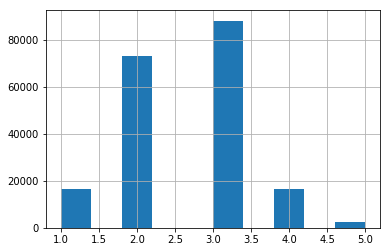

count    196836.000000
mean          2.568915
std           0.808873
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
dtype: float64

In [50]:
sentence_len = [len(x) for tokens in description_tokens for x in tokens]
pd.Series(sentence_len).hist()
plt.show()
pd.Series(sentence_len).describe()

In [51]:
MAX_SEQ_LEN = 5
padded_tokens = pad_tokens(description_tokens, MAX_SEQ_LEN)

In [52]:
resize_imgs = [pad_and_resize_imgs(x) for x in tqdm(images, position = 0, leave = True)]

100%|██████████| 98418/98418 [05:40<00:00, 289.38it/s]


In [53]:
len(padded_tokens) == len(resize_imgs)

True

In [54]:
non_fbumper_tokens = []
fbumper_tokens = []
for i, x in enumerate(single_label_descriptions):
    if x not in front_bumper_syn:
        non_fbumper_tokens.append(padded_tokens[i])
    else:
        fbumper_tokens.append(padded_tokens[i])

In [55]:
len(fbumper_tokens)

89432

In [56]:
len(fbumper_tokens)

107404

In [57]:
non_fbumper_unq_tokens = np.unique(non_fbumper_tokens, axis = 0)
fbumper_unq_tokens = np.unique(fbumper_tokens, axis = 0)

In [58]:
fbumper_unq_tokens

array([[ 0,  0,  0,  7,  8],
       [ 0,  0,  0,  7,  9],
       [ 0,  0,  0,  7, 14],
       [ 0,  0,  0,  9,  7],
       [ 0,  0,  2,  1,  3],
       [ 0,  0,  3,  2,  1],
       [ 0,  0,  5,  1,  3],
       [ 0,  0,  5,  1,  8]])

## Model Implementation

In [59]:
def triplet_loss(y_true, y_pred, alpha=0.7):
    """
    https://github.com/KinWaiCheuk/Triplet-net-keras/blob/master/Triplet%20NN%20Test%20on%20MNIST.ipynb
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    total_length = y_pred.shape.as_list()[-1]
    anchor = y_pred[:, 0:int(total_length * 1 / 3)]
    positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
    negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor - positive), axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0)

    return loss

In [61]:
ids = list(range(len(resize_imgs)))
len([x for i, x in enumerate(ids) for _ in range(len(padded_tokens[i]))])

196836

In [64]:
vec_dim = 100

def gen(list_images, list_captions, batch_size=16):
    indexes = list(range(len(list_images)))
    while True:
        
        batches = chunker(indexes, batch_size, shuffle = True)
        
        for batch_indexes in batches:
            batch_imgs = [list_images[i] for i in batch_indexes]
            captions_p = [list_captions[i] for i in batch_indexes]
            captions_n = []
            
            X1 = np.array([preprocess_input(x) for x in batch_imgs])
            X2 = np.array(captions_p)
            try:
                batch_non_fbumper_tokens = []
                batch_fbumper_tokens = []
                for cap in captions_p:
                    if cap.tolist() in fbumper_unq_tokens.tolist():
                        batch_fbumper_tokens.append(cap)
                    else:
                        batch_non_fbumper_tokens.append(cap)

                batch_non_fbumper_unq_tokens = np.unique(batch_non_fbumper_tokens, axis = 0)
                batch_fbumper_unq_tokens = np.unique(batch_fbumper_tokens, axis = 0)

                for pos_cap in captions_p:
                    if pos_cap.tolist() in batch_fbumper_unq_tokens.tolist():
                        neg_cap = choice(batch_non_fbumper_unq_tokens)
                    else:
                        neg_cap = choice(batch_fbumper_unq_tokens)

                    captions_n.append(neg_cap)
                    
            except:
                for pos_cap in captions_p:
                    eq = True
                    neg_cap = 0
                    while eq:
                        neg_cap = choice(non_fbumper_unq_tokens)
                        if neg_cap.tolist() != pos_cap.tolist():
                            eq = False
                    captions_n.append(neg_cap)
                
                
            X3 = np.array(captions_n)
            
            yield [X1, X2, X3], np.zeros((len(X1), 3 * vec_dim))

In [65]:
vec_dim = 100

def gen_1(list_images, list_captions, batch_size=16):
    indexes = list(range(len(list_images)))
    while True:
        
        batches = chunker(indexes, batch_size, shuffle = True)
        
        for batch_indexes in batches:
            batch_imgs = [list_images[i] for i in batch_indexes]
            captions_p = [list_captions[i] for i in batch_indexes]
            captions_n = [choice(list_captions) for _ in batch_indexes]
            
            X1 = np.array([preprocess_input(x) for x in batch_imgs])
            X2 = np.array(captions_p)                
            X3 = np.array(captions_n)
            
            yield [X1, X2, X3], np.zeros((len(X1), 3 * vec_dim))

In [71]:
next(gen(resize_imgs, padded_tokens))

([array([[[[-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           ...,
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ]],
  
          [[-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           ...,
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ]],
  
          [[-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           ...,
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ]],
  
          ...,
  
          [[-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           [-103.939, -116.779, -123.68 ],
           ...,
   

In [72]:
def model(vocab_size, lr=0.0001):
    input_1 = Input(shape=(None, None, 3))
    input_2 = Input(shape=(None,))
    input_3 = Input(shape=(None,))

    base_model = ResNet50(weights='imagenet', include_top=False)

    x1 = base_model(input_1)
    x1 = GlobalMaxPool2D()(x1)

    dense_1 = Dense(vec_dim, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)

    embed = Embedding(vocab_size, 300, weights=[emb_weights],  name="word2vec_embed", trainable = False)

    gru = Bidirectional(GRU(256, return_sequences=True), merge_mode= name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    x3 = embed(input_3)
    x3 = gru(x3)
    x3 = GlobalMaxPool1D()(x3)
    x3 = dense_2(x3)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)
    x2 = _norm(x2)
    x3 = _norm(x3)

    x = Concatenate(axis=-1)([x1, x2, x3])

    model = Model([input_1, input_2, input_3], x)

    model.compile(loss=triplet_loss, optimizer=Adam(lr))

    model.summary()

    return model

In [73]:
model = model(vocab_size = vocab_size + 1, lr=0.000001)

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
word2vec_embed (Embedding)      (None, None, 300)    10800       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________

In [75]:
#Split the data into train and val
from sklearn.model_selection import train_test_split

idx_list = list(range(len(resize_imgs)))

train_idx, val_idx = train_test_split(idx_list, test_size = 0.8, shuffle = True, random_state = 2020)

train_imgs, train_p_captions = [resize_imgs[i] for i in train_idx], [padded_tokens[i] for i in train_idx]
val_imgs, val_p_captions = [resize_imgs[i] for i in val_idx], [padded_tokens[i] for i in val_idx]

In [76]:
file_path = "model_triplet_fbumper_100k_random.h5"
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_ = ReduceLROnPlateau(monitor="val_loss", mode='min', patience=5, min_lr=1e-7)

history = model.fit_generator(gen_1(train_imgs, train_p_captions, batch_size=BATCH_SIZE),
                    use_multiprocessing=False, max_queue_size = 100,
                    validation_data=gen_1(val_imgs, val_p_captions, batch_size=BATCH_SIZE), epochs=100,
                    verbose=1, workers=10, steps_per_epoch=np.ceil(len(train_imgs)/BATCH_SIZE), validation_steps=np.ceil(len(val_imgs)/BATCH_SIZE), callbacks=[es, checkpoint, reduce_])
model.save_weights(file_path)

Epoch 1/100
1230/1231 [============================>.] - ETA: 0s - loss: 0.6846
Epoch 00001: val_loss improved from inf to 0.66841, saving model to model_triplet_fbumper_100k_bonnet_32.h5
1231/1231 [==============================] - 1252s 1s/step - loss: 0.6847 - val_loss: 0.6684
Epoch 2/100
1230/1231 [============================>.] - ETA: 0s - loss: 0.6531
Epoch 00002: val_loss improved from 0.66841 to 0.62445, saving model to model_triplet_fbumper_100k_bonnet_32.h5
1231/1231 [==============================] - 1228s 997ms/step - loss: 0.6530 - val_loss: 0.6244
Epoch 3/100
1230/1231 [============================>.] - ETA: 0s - loss: 0.6213
Epoch 00003: val_loss improved from 0.62445 to 0.59758, saving model to model_triplet_fbumper_100k_bonnet_32.h5
1231/1231 [==============================] - 1219s 991ms/step - loss: 0.6214 - val_loss: 0.5976
Epoch 4/100
1230/1231 [============================>.] - ETA: 0s - loss: 0.5890
Epoch 00004: val_loss improved from 0.59758 to 0.56358, saving 

In [78]:
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'lr'])


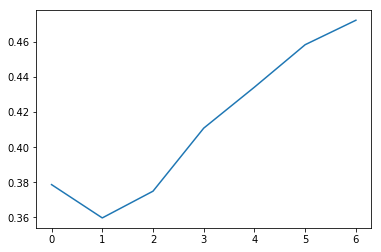

In [79]:
plt.plot(history.history['val_loss'])

In [116]:
def image_model(lr=0.0001):
    input_1 = Input(shape=(None, None, 3))

    base_model = ResNet50(weights='imagenet', include_top=False)

    x1 = base_model(input_1)
    x1 = GlobalMaxPool2D()(x1)

    dense_1 = Dense(vec_dim, activation="linear", name="dense_image_1")

    x1 = dense_1(x1)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x1 = _norm(x1)

    model = Model([input_1], x1)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model

def text_model(vocab_size, lr=0.0001):
    input_2 = Input(shape=(None,))

    embed = Embedding(vocab_size, 300, weights=[emb_weights],  name="word2vec_embed", trainable = False)
    gru = Bidirectional(GRU(256, return_sequences=True), name="gru_1")
    dense_2 = Dense(vec_dim, activation="linear", name="dense_text_1")

    x2 = embed(input_2)
    x2 = gru(x2)
    x2 = GlobalMaxPool1D()(x2)
    x2 = dense_2(x2)

    _norm = Lambda(lambda x: K.l2_normalize(x, axis=-1))

    x2 = _norm(x2)

    model = Model([input_2], x2)

    model.compile(loss="mae", optimizer=Adam(lr))

    model.summary()

    return model

In [117]:
file_path = "model_triplet_fbumper_100k_batch_32.h5"

t_model = text_model(vocab_size = vocab_size + 1)
i_model = image_model()

t_model.load_weights(file_path, by_name=True)
i_model.load_weights(file_path, by_name=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, None)              0         
_________________________________________________________________
word2vec_embed (Embedding)   (None, None, 300)         10200     
_________________________________________________________________
gru_1 (Bidirectional)        (None, None, 512)         855552    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_text_1 (Dense)         (None, 50)                25650     
_________________________________________________________________
lambda_4 (Lambda)            (None, 50)                0         
Total params: 891,402
Trainable params: 881,202
Non-trainable params: 10,200
_________________________________________________________________

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
_________________________________________________________________
dense_image_1 (Dense)        (None, 50)                102450    
_________________________________________________________________
lambda_5 (Lambda)            (None, 50)                0         
Total params: 23,690,162
Trainable params: 23,637,042
Non-trainable params: 53,120
_________________________________________________________________


In [82]:
test_images = clean_fbumper['image_id'].values

In [83]:
test_set_data = data.loc[data['set'] == 2, 'image_id'].values

In [ ]:
import shutil

image_filepath = '/data/data_for_thevin/data_for_thevin/images'

dest = os.path.join("/data/thevin/",'fbumper_test_50k')
if not os.path.exists(dest):
    os.mkdir(dest)

for i, name in enumerate(test_images):
    if name in test_set_data:
        path = os.path.join(image_filepath, name + '.jpg')
        shutil.copy(path, dest)
    clear_output(True)
    print("Completed {}/{}".format(i + 1, len(test_images)))

In [84]:
test_images = load_images_from_folder(os.path.join("/data/thevin/",'fbumper_test_50k'))

Completed 22202/22202


In [85]:
test_image_names = [x[:-4] for x in list(test_images.keys())]

In [86]:
fbumper_df = clean_fbumper.set_index('image_id').loc[test_image_names, 'fbumper:replace'].reset_index(inplace=False)
test_ground_truths = list(fbumper_df['fbumper:replace'])

In [87]:
test_images_values = list(test_images.values())

In [88]:
test_imgs = [pad_and_resize_imgs(x) for x in tqdm(test_images_values, position = 0, leave = True)]

100%|██████████| 22202/22202 [01:13<00:00, 302.85it/s]


In [118]:
from tqdm import tqdm


target_image_encoding = []

for img in tqdm(chunker(test_imgs, 128), total=len(test_imgs)//128, position = 0, leave = True):
    image_vecs = np.asarray([preprocess_input(img[i]) for i in range(len(img))])
    e = i_model.predict(image_vecs)
    target_image_encoding += e.tolist()

174it [02:00,  1.44it/s]                         


In [119]:
query_text = ['cover frt bumper', 'back bumper']

cleaned_text = clean_punc(query_text)
query_tokens = tokenizer(cleaned_text)
pad_query_tokens = pad_tokens(query_tokens, MAX_SEQ_LEN)

target_text_encoding = t_model.predict(np.asarray(pad_query_tokens), verbose = 2)

In [120]:
np.shape(target_text_encoding)

(2, 50)

In [121]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_jobs=-1, n_neighbors=1000)
nn.fit(target_image_encoding)

distances_, preds_ = nn.kneighbors(target_text_encoding, return_distance=True)

In [122]:
preds = np.asarray([x[:12] for x in preds_])
distances = np.asarray([x[:12] for x in distances_])

In [ ]:
most_similar_images = []
query_image = []
count = 0


for i in range(len(preds)):
    pred_imgs = [test_imgs[x] for x in preds[i]]
    most_similar_images.append(pred_imgs)

for q, all_images in zip(query_text, most_similar_images):
    fig, axes = plt.subplots(4, 3, figsize = (12, 13))

    for idx, img_path in enumerate(all_images):
        i = idx // 3  # Get subplot row
        j = idx % 3  # Get subplot column
        axes[i, j].imshow(img_path, cmap = 'gray')
        axes[i, j].set_title('Distance {}'.format(distances[count, idx]))

    count += 1
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    fig.suptitle('Query : %s'%q)
    
    #plt.savefig('{}_cat_common_50.png'.format(q), dpi = 1500)


# Reverse Search

In [ ]:
len(common_text_compr)

In [103]:
common_text_compr

['front bumper',
 'front bumper auxiliary',
 'left head lamp',
 'grille',
 'right head lamp',
 'back bumper',
 'front left wing auxiliary',
 'front right wing auxiliary',
 'bonnet',
 'front left wing',
 'front right wing',
 'bonnet auxiliary',
 'front left door auxiliary',
 'front bumper impact bar',
 'front right door auxiliary',
 'front bumper impact bar auxiliary ',
 'back bumper auxiliary',
 'brwing auxiliary',
 'right mirror',
 'right rocker panel auxiliary',
 'blwing auxiliary',
 'left mirror',
 'front left door',
 'roof moulding',
 'grille auxiliary',
 'front right door',
 'bootlid auxiliary',
 'left rocker panel auxiliary',
 'rldoor auxiliary',
 'rrdoor auxiliary',
 'bootlid',
 'front bumper lfoglamp',
 'front bumper rfoglamp',
 'brwing',
 'front left door moulding',
 'blwing',
 'rtaillamp',
 'ltaillamp',
 'roof auxiliary',
 'front right door moulding',
 'rldoor',
 'right head lamp auxiliary',
 'rrdoor',
 'rbodypanel',
 'right mirror cover',
 'left mirror cover',
 'back bumper 

In [ ]:
fbumper_syn

In [124]:
text = ['cover front bumper', 'back bumper']

cleaned_text = clean_punc(text)
query_tokens = tokenizer(cleaned_text)
padded_tokens_ = pad_tokens(query_tokens, MAX_SEQ_LEN)

text_encodings = t_model.predict(np.asarray(padded_tokens_), verbose = 2)

In [96]:
target_image_encoding = []

query_images = test_imgs

image_vecs = np.asarray([preprocess_input(query_images[i]) for i in range(len(query_images))])
e = i_model.predict(image_vecs)
target_image_encoding += e.tolist()

In [125]:
nn_text = NearestNeighbors(n_jobs=1, n_neighbors=len(text))
nn_text.fit(text_encodings)

distances_text, preds_text = nn_text.kneighbors(target_image_encoding, return_distance=True)

In [126]:
all_label_distances = np.zeros_like(distances_text)

for i, (dist, pred) in enumerate(zip(distances_text, preds_text)):
    label_distances = [x for y, x in sorted(zip(pred, dist))]
    all_label_distances[i] = label_distances

In [127]:
all_label_distances[:, 0]

array([1.13927775, 1.14918166, 1.2091933 , ..., 1.30655111, 1.10928815,
       0.98397407])

In [128]:
damaged_distances = []
undamaged_distances = []

for i, x in enumerate(test_ground_truths):
    if x == 1:
        damaged_distances.append(all_label_distances[i, 0])
    else:
        undamaged_distances.append(all_label_distances[i, 0])
        

In [129]:
len(damaged_distances), len(undamaged_distances)

(17698, 4504)

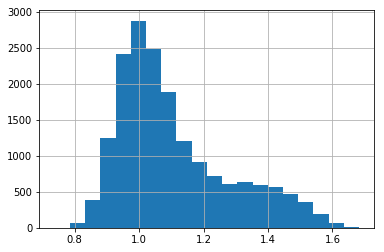

count    17698.000000
mean         1.106126
std          0.173395
min          0.738304
25%          0.979299
50%          1.055685
75%          1.197939
max          1.682309
dtype: float64

In [130]:
pd.Series(damaged_distances).hist(bins = 20)
plt.show()
pd.Series(damaged_distances).describe()

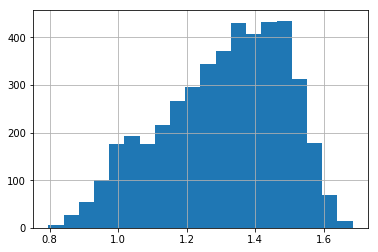

count    4504.000000
mean        1.307791
std         0.177968
min         0.796254
25%         1.182200
50%         1.333247
75%         1.450097
max         1.685014
dtype: float64

In [131]:
pd.Series(undamaged_distances).hist(bins = 20)
plt.show()
pd.Series(undamaged_distances).describe()

In [132]:
def pred_mapping(distances, preds, threshold):
    binary_preds = []
    for (dist, pred) in zip(distances, preds):
        label_distances = [x for y, x in sorted(zip(pred, dist))]
        fbumper_dist = label_distances[0]
        if fbumper_dist <= threshold:
            binary_preds.append(1)
        else:
            binary_preds.append(0)
    return binary_preds

In [145]:
binary_preds = pred_mapping(distances_text, preds_text, 1.2)

In [146]:
pred_damaged = []
pred_undamaged = []

for i, x in enumerate(test_ground_truths):
    if x == 1:
        pred_damaged.append(binary_preds[i])
    else:
        pred_undamaged.append(binary_preds[i])

In [147]:
from sklearn.metrics import accuracy_score

accuracy_score(y_pred=binary_preds, y_true=test_ground_truths)

0.7466894874335646

In [148]:
print('{} Damaged Accuracy \n{} Undamaged Accuracy'.format(accuracy_score(y_pred = pred_damaged, y_true= [1]*len(pred_damaged)),
                                                           accuracy_score(y_pred = pred_undamaged, y_true= [0]*len(pred_undamaged))))

0.7524014012882811 Damaged Accuracy 
0.7242451154529307 Undamaged Accuracy


In [149]:
np.mean([accuracy_score(y_pred = pred_damaged, y_true= [1]*len(pred_damaged)),
                                                           accuracy_score(y_pred = pred_undamaged, y_true= [0]*len(pred_undamaged))])

0.7383232583706059

In [154]:
threshold_values = [1.1, 1.2, 1.3, 1.4, 1.5]
max_acc = 0
max_acc_thresh = 0

for i in threshold_values:
    binary_preds = pred_mapping(distances_text, preds_text, i)
    
    pred_damaged = []
    pred_undamaged = []

    for idx, x in enumerate(test_ground_truths):
        if x == 1:
            pred_damaged.append(binary_preds[idx])
        else:
            pred_undamaged.append(binary_preds[idx])
    
    dam_acc = accuracy_score(y_pred = pred_damaged, y_true= [1]*len(pred_damaged))
    undam_acc = accuracy_score(y_pred = pred_undamaged, y_true= [0]*len(pred_undamaged))
    mean_acc = np.mean([dam_acc, undam_acc])
    if mean_acc > max_acc:
        max_acc = mean_acc
        max_acc_thresh = i
        
print(max_acc, max_acc_thresh)

0.7383232583706059 1.2


In [125]:
from sklearn.metrics import f1_score, recall_score

f1_damaged = f1_score(y_pred=binary_preds, y_true=test_ground_truths, average = 'weighted')
f1_undamaged = f1_score(y_pred=binary_preds, y_true=test_ground_truths, average = 'weighted')

recall_score = recall_score(y_pred=binary_preds, y_true=test_ground_truths, average = 'weighted')

print(f1_damaged, f1_undamaged, recall_score)

0.7204166297790976 0.7204166297790976 0.691244032069183


In [123]:
Counter(test_ground_truths)

Counter({0: 4504, 1: 17698})

In [ ]:
plt.imshow(test_imgs[13])

In [181]:
binary_preds[13], test_ground_truths[13]

(0, 1)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize = (10, 10))
for i in range(4):
    ax = axes[i]
    ax.imshow(query_images[i])
    ax.set_title("Query Image %s"%(i + 1))
plt.tight_layout()
plt.show()

In [114]:
for img in range(4):
    print("\nText Results for Image {}: \n".format(img + 1))
    for n in range(5):
        print("Text: {:>30} \t Distance: {}".format(common_text[preds_text[img, n]], distances_text[img, n]))


Text Results for Image 1: 

Text:               frt bumper cover 	 Distance: 0.8283585873260687
Text:             cover front bumper 	 Distance: 1.004734417438029
Text:             reinf front bumper 	 Distance: 1.1108477877974219
Text:       brkt front bumper mtg rt 	 Distance: 1.1313845800953166
Text:          absorber front bumper 	 Distance: 1.2002995436408512

Text Results for Image 2: 

Text:                 r fender panel 	 Distance: 0.8161453508119828
Text:                 l fender panel 	 Distance: 0.8728903557268125
Text:                 r fender liner 	 Distance: 1.0515356728909384
Text:                     hood panel 	 Distance: 1.0936171962610985
Text:        r frt otr belt moulding 	 Distance: 1.0985950143845893

Text Results for Image 3: 

Text:                grille assembly 	 Distance: 0.7528252738689917
Text:                         grille 	 Distance: 0.8065327041963776
Text:                    grille assy 	 Distance: 0.839851781866243
Text:                     panel

In [ ]:
print(cleaned_descriptions[test_idx[preds[0, 0]]], "\n", cleaned_descriptions[test_idx[preds[2, 0]]], "\n", cleaned_descriptions[test_idx[preds[4, 0]]], "\n", cleaned_descriptions[test_idx[preds[5, 0]]])